In [1]:
#handle warnings
import warnings
warnings.filterwarnings("ignore")

# Graphics
import matplotlib.pyplot as plt
from matplotlib import colors

# Analysis
import numpy as np
import geopandas as gpd
import pandas as pd
import statsmodels.formula.api as smf  #https://www.statsmodels.org/dev/api.html#statsmodels-formula-api
import statsmodels.api as sm

**Registered Patients**

In [2]:
reg_pats = pd.read_csv('data/gp_regpatage_data_oct25.csv')

In [3]:
reg_pats

,area_code,ons_code,sex,age_group,count_pats
0,00L,E38000130,all,all,343729
1,00L,E38000130,female,0_4,6540
2,00L,E38000130,female,65_69,13140
3,00L,E38000130,female,70_74,11216
4,00L,E38000130,female,75_79,11012
...,...,...,...,...,...
2009,X2C4Y,E38000254,male,80_84,5065
2010,X2C4Y,E38000254,male,85_89,2758
2011,X2C4Y,E38000254,male,90_94,982
2012,X2C4Y,E38000254,male,95p,222


In [4]:
tot_pats = (
    reg_pats[
        (reg_pats['sex'] == 'all') & 
        (reg_pats['age_group']== 'all')
         ]
    .set_index('area_code')['count_pats']
    .rename('tot_pats')
)

In [5]:
age_0_4 = (
    reg_pats[
        (reg_pats['age_group'] == '0_4') & 
        (reg_pats['sex'].isin(['male', 'female']))
    ]
    .groupby('area_code')['count_pats'].sum().rename('pats_0_4')
)

In [6]:
age_65p_groups = ['65_69', '70_74', '75_79', '80_84', '85_90', '90_94', '95p']

age_65p = (
    reg_pats[
        (reg_pats['age_group'].isin(age_65p_groups)) & 
        (reg_pats['sex'].isin(['male', 'female']))
    ]
    .groupby('area_code')['count_pats'].sum().rename('pats_65p')
)

In [7]:
age_regpats = (
    pd.concat([tot_pats, age_0_4, age_65p], axis=1).reset_index()
)

In [8]:
age_regpats

,area_code,tot_pats,pats_0_4,pats_65p
0,00L,343729,13510,84816
1,00N,159601,7060,31134
2,00P,295469,13159,55587
3,00Q,188514,10522,25503
4,00R,179394,7877,34361
...,...,...,...,...
101,D9Y0V,1737087,73722,348932
102,M1J4Y,1149790,63268,159383
103,M2L0M,538218,22976,113951
104,W2U3Z,2932599,121948,305686


In [9]:
#create % patients 0-4 and 65+ in each sicb
age_regpats['pct_pats_0_4'] = ((age_regpats['pats_0_4'] / age_regpats['tot_pats']) * 100)
age_regpats['pct_pats_65p'] = ((age_regpats['pats_65p'] / age_regpats['tot_pats']) * 100)

In [10]:
age_regpats

,area_code,tot_pats,pats_0_4,pats_65p,pct_pats_0_4,pct_pats_65p
0,00L,343729,13510,84816,3.930422,24.675253
1,00N,159601,7060,31134,4.423531,19.507397
2,00P,295469,13159,55587,4.453598,18.813141
3,00Q,188514,10522,25503,5.581548,13.528438
4,00R,179394,7877,34361,4.390894,19.153929
...,...,...,...,...,...,...
101,D9Y0V,1737087,73722,348932,4.244002,20.087192
102,M1J4Y,1149790,63268,159383,5.502570,13.861923
103,M2L0M,538218,22976,113951,4.268902,21.171904
104,W2U3Z,2932599,121948,305686,4.158359,10.423723


In [11]:
age_regpats.to_csv("data/age_regpats.csv", index=False) #create csv of registered patients totals and % 0-4 and 65+

**GP Appointment Waiting Times and Modes**

In [12]:
gpappts = pd.read_csv('data/gp_appts_data_oct25.csv')

In [13]:
gpappts

,area_code,ons_code,sicb_name,count_appttime,same_day,1_day,2_7days,8_14days,15_21days,22_28days,28p_days,unknown_days,count_apptmode,face_face,home_visit,telephone,video_online,unkown_mode
0,02P,E38000006,NHS South Yorkshire ICB - 02P,171375,64704,10269,24174,19216,14922,12130,25887,73,171375,129553,1267,28888,7298,4369
1,99E,E38000007,NHS Mid and South Essex ICB - 99E,188693,83342,16005,31109,21347,14827,9296,12546,221,188693,127982,456,43154,11593,5508
2,02Q,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,134544,71388,9890,16904,9898,8294,8200,9741,229,134544,71054,1550,18195,40383,3362
3,00Q,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,100003,42524,7008,17090,13812,8984,6370,4199,16,100003,74226,1104,20207,2459,2007
4,00R,E38000015,NHS Lancashire and South Cumbria ICB - 00R,101934,33211,8547,18140,15133,9475,7872,9505,51,101934,72153,1666,25236,1798,1081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,15M,E38000261,NHS Derby and Derbyshire ICB - 15M,761136,249911,48648,117360,93296,62806,54396,132999,1720,761136,547764,11723,128371,48227,25051
102,78H,E38000262,NHS Northamptonshire ICB - 78H,541978,209348,37923,91667,66841,40624,33880,61441,254,541978,355693,4265,101318,65676,15026
103,01Y,E38000263,NHS Greater Manchester ICB - 01Y,126980,44142,10977,24061,18073,12136,7930,9285,376,126980,84947,2477,30880,4847,3829
104,92A,E38000264,NHS Surrey Heartlands ICB - 92A,711171,289879,47821,109928,85370,52395,43758,81628,392,711171,454905,7356,153100,89079,6731


In [14]:
#calculate % over 14 days wait
gpappts['pct_over14'] = (
    (gpappts['15_21days'] + gpappts['22_28days'] + gpappts['28p_days']) / 
    gpappts['count_appttime']*100)

In [15]:
#calculate % remote (telephone + video/online) appointments
gpappts['pct_remote'] = (
    (gpappts['telephone'] + gpappts['video_online']) / 
    gpappts['count_apptmode']*100)

In [16]:
gpappts['pct_remote'].describe()

count    106.000000
mean      27.662218
std        5.837313
min       12.267734
25%       23.850973
50%       27.466697
75%       30.780503
max       45.829781
Name: pct_remote, dtype: float64

In [17]:
gpappts['pct_over14'].describe()

count    106.000000
mean      25.192912
std        5.865875
min       10.424956
25%       21.577260
50%       25.449738
75%       29.003904
max       37.147239
Name: pct_over14, dtype: float64

In [18]:
#calculate % face to face appointments
gpappts['pct_ftof'] = (gpappts['face_face'] / gpappts['count_apptmode']*100)

In [19]:
gpappts['pct_ftof'].describe()

count    106.000000
mean      68.711538
std        5.809885
min       51.938033
25%       65.644605
50%       68.967902
75%       72.473149
max       84.103567
Name: pct_ftof, dtype: float64

In [20]:
#calculate % same or 1 days wait
gpappts['pct_same_1'] = (
    (gpappts['same_day'] + gpappts['1_day']) / 
    gpappts['count_appttime']*100)

In [21]:
#calculate % more than 28 days wait
gpappts['pct_28p'] = (gpappts['28p_days'] / 
    gpappts['count_appttime']*100)

In [22]:
gpappts

,area_code,ons_code,sicb_name,count_appttime,same_day,1_day,2_7days,8_14days,15_21days,22_28days,...,face_face,home_visit,telephone,video_online,unkown_mode,pct_over14,pct_remote,pct_ftof,pct_same_1,pct_28p
0,02P,E38000006,NHS South Yorkshire ICB - 02P,171375,64704,10269,24174,19216,14922,12130,...,129553,1267,28888,7298,4369,30.890737,21.115098,75.596207,43.747921,15.105470
1,99E,E38000007,NHS Mid and South Essex ICB - 99E,188693,83342,16005,31109,21347,14827,9296,...,127982,456,43154,11593,5508,19.433153,29.013795,67.825516,52.650072,6.648895
2,02Q,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,134544,71388,9890,16904,9898,8294,8200,...,71054,1550,18195,40383,3362,19.499197,43.538173,52.810976,60.409977,7.240011
3,00Q,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,100003,42524,7008,17090,13812,8984,6370,...,74226,1104,20207,2459,2007,19.552413,22.665320,74.223773,49.530514,4.198874
4,00R,E38000015,NHS Lancashire and South Cumbria ICB - 00R,101934,33211,8547,18140,15133,9475,7872,...,72153,1666,25236,1798,1081,26.342535,26.521082,70.784037,40.965723,9.324661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,15M,E38000261,NHS Derby and Derbyshire ICB - 15M,761136,249911,48648,117360,93296,62806,54396,...,547764,11723,128371,48227,25051,32.872049,23.201898,71.966639,39.225447,17.473750
102,78H,E38000262,NHS Northamptonshire ICB - 78H,541978,209348,37923,91667,66841,40624,33880,...,355693,4265,101318,65676,15026,25.083121,30.811952,65.628679,45.623808,11.336438
103,01Y,E38000263,NHS Greater Manchester ICB - 01Y,126980,44142,10977,24061,18073,12136,7930,...,84947,2477,30880,4847,3829,23.114664,28.135927,66.897937,43.407623,7.312175
104,92A,E38000264,NHS Surrey Heartlands ICB - 92A,711171,289879,47821,109928,85370,52395,43758,...,454905,7356,153100,89079,6731,24.998348,34.053554,63.965629,47.485063,11.477971


In [23]:
gpwaitsmode = gpappts[['area_code', 'ons_code', 'sicb_name', 'count_appttime', 'pct_same_1' , 'pct_over14', 'pct_28p', 'pct_remote', 'pct_ftof']] #new df with selected columns

In [24]:
gpwaitsmode.to_csv("data/gpwaitsmode.csv", index=False) #create csv of % gp waits and modes

**Full-time Equivalent GP Supply**

In [25]:
gp_counts = pd.read_csv('data/gp_ftegp_data_oct25.csv')

In [26]:
gp_counts

,area_code,sicb_name,count_gps_all
0,72Q,NHS South East London ICB - 72Q,1094.489450
1,A3A8R,NHS North East London ICB - A3A8R,1219.215724
2,93C,NHS North Central London ICB - 93C,1031.747953
3,W2U3Z,NHS North West London ICB - W2U3Z,1326.530421
4,36L,NHS South West London ICB - 36L,1032.717482
...,...,...,...
101,02T,NHS West Yorkshire ICB - 02T Calderdale,164.868267
102,03R,NHS West Yorkshire ICB - 03R Wakefield,296.772160
103,15F,NHS West Yorkshire ICB - 15F Leeds,616.753660
104,36J,NHS West Yorkshire ICB - 36J Bradford District...,427.467455


In [27]:
gp_regpats = age_regpats.merge(gp_counts, on='area_code', how='left')

In [28]:
gp_regpats

,area_code,tot_pats,pats_0_4,pats_65p,pct_pats_0_4,pct_pats_65p,sicb_name,count_gps_all
0,00L,343729,13510,84816,3.930422,24.675253,NHS North East and North Cumbria ICB - 00L Nor...,258.546400
1,00N,159601,7060,31134,4.423531,19.507397,NHS North East and North Cumbria ICB - 00N Sou...,92.475733
2,00P,295469,13159,55587,4.453598,18.813141,NHS North East and North Cumbria ICB - 00P Sun...,196.646815
3,00Q,188514,10522,25503,5.581548,13.528438,NHS Lancashire and South Cumbria ICB - 00Q Bla...,94.829372
4,00R,179394,7877,34361,4.390894,19.153929,NHS Lancashire and South Cumbria ICB - 00R Bla...,106.880477
...,...,...,...,...,...,...,...,...
101,D9Y0V,1737087,73722,348932,4.244002,20.087192,NHS Hampshire and Isle Of Wight ICB - D9Y0V Ha...,1060.780147
102,M1J4Y,1149790,63268,159383,5.502570,13.861923,"NHS Bedfordshire, Luton and Milton Keynes ICB ...",566.509304
103,M2L0M,538218,22976,113951,4.268902,21.171904,"NHS Shropshire, Telford and Wrekin ICB - M2L0M",293.903184
104,W2U3Z,2932599,121948,305686,4.158359,10.423723,NHS North West London ICB - W2U3Z,1326.530421


In [29]:
#calculate patients per GP
gp_regpats['pats_per_gp'] = (gp_regpats['tot_pats'] / gp_regpats['count_gps_all'])

In [30]:
gp_regpats[['count_gps_all', 'pats_per_gp']].describe()

,count_gps_all,pats_per_gp
count,106.000000,106.000000
mean,354.519943,1691.733406
std,288.123329,225.253789
min,69.867731,1252.389901
25%,154.862798,1508.305309
50%,236.407381,1671.100272
75%,471.329202,1826.973409
max,1326.530421,2406.340301


**Incomplete RTT Pathways Waits**

In [31]:
rtt_waits = pd.read_csv('data/rtt_incomp_data_oct25.csv')

In [32]:
rtt_waits

,area_code,pct_rttwaits_18wks
0,36L,64.193132
1,72Q,62.706497
2,93C,60.523651
3,A3A8R,63.352480
4,W2U3Z,61.585269
...,...,...
101,36J,67.339058
102,42D,64.198335
103,84H,70.594868
104,99C,79.199296


**QOF Health Prevalence**

In [33]:
qof_health = pd.read_csv('data/qof_prevalence_data_24_25.csv')

In [34]:
qof_health

,area_code,ons_code,pctpats_depression,pctpats_obesity,pctpats_hypertension,pctpats_copd,pctpats_prediabetes,pctpats_mh,pctpats_diabetes,pctpats_asthma
0,92G,E38000231,12.314387,13.859199,15.965855,1.835327,10.390387,0.893417,7.588900,7.338196
1,M1J4Y,E38000249,11.399778,12.462154,14.080204,1.566221,11.454510,0.968785,8.754755,6.406090
2,15E,E38000258,12.767655,14.435920,13.072790,1.460017,9.512384,1.257321,9.315669,6.345788
3,D2P2L,E38000259,14.804840,18.600350,16.178515,2.063245,8.557150,1.014822,9.999188,6.588842
4,15C,E38000222,15.747679,12.120879,13.790692,1.852338,9.127381,0.903010,6.730963,6.705184
...,...,...,...,...,...,...,...,...,...,...
101,02T,E38000025,17.998442,13.304406,15.755057,2.230216,14.360258,1.213018,9.117642,7.618243
102,03R,E38000190,15.783141,17.399587,17.396828,2.696153,8.976147,0.943066,8.768886,7.737205
103,15F,E38000225,12.819410,13.146722,13.777790,1.878034,8.900509,1.001399,7.004909,6.236095
104,36J,E38000232,14.508864,16.934486,15.001269,2.014606,13.413372,1.185616,10.324981,7.602620


**Merge Datasets**

In [35]:
dataset = gpwaitsmode.merge(gp_regpats, on='area_code', how='left')

In [36]:
dataset.isna().sum()

area_code         0
ons_code          0
sicb_name_x       0
count_appttime    0
pct_same_1        0
pct_over14        0
pct_28p           0
pct_remote        0
pct_ftof          0
tot_pats          0
pats_0_4          0
pats_65p          0
pct_pats_0_4      0
pct_pats_65p      0
sicb_name_y       0
count_gps_all     0
pats_per_gp       0
dtype: int64

In [37]:
dataset = dataset.merge(rtt_waits, on='area_code', how='left')

In [38]:
dataset

,area_code,ons_code,sicb_name_x,count_appttime,pct_same_1,pct_over14,pct_28p,pct_remote,pct_ftof,tot_pats,pats_0_4,pats_65p,pct_pats_0_4,pct_pats_65p,sicb_name_y,count_gps_all,pats_per_gp,pct_rttwaits_18wks
0,02P,E38000006,NHS South Yorkshire ICB - 02P,171375,43.747921,30.890737,15.105470,21.115098,75.596207,270773,12831,49776,4.738656,18.382926,NHS South Yorkshire ICB - 02P Barnsley,155.734077,1738.688186,70.923758
1,99E,E38000007,NHS Mid and South Essex ICB - 99E,188693,52.650072,19.433153,6.648895,29.013795,67.825516,296466,15822,48500,5.336868,16.359380,NHS Mid and South Essex ICB - 99E Basildon and...,134.528800,2203.736300,51.967487
2,02Q,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,134544,60.409977,19.499197,7.240011,43.538173,52.810976,128933,5867,26124,4.550425,20.261686,NHS Nottingham and Nottinghamshire ICB - 02Q B...,76.756267,1679.771641,60.616861
3,00Q,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,100003,49.530514,19.552413,4.198874,22.665320,74.223773,188514,10522,25503,5.581548,13.528438,NHS Lancashire and South Cumbria ICB - 00Q Bla...,94.829372,1987.928376,61.099248
4,00R,E38000015,NHS Lancashire and South Cumbria ICB - 00R,101934,40.965723,26.342535,9.324661,26.521082,70.784037,179394,7877,34361,4.390894,19.153929,NHS Lancashire and South Cumbria ICB - 00R Bla...,106.880477,1678.454334,58.660849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,15M,E38000261,NHS Derby and Derbyshire ICB - 15M,761136,39.225447,32.872049,17.473750,23.201898,71.966639,1145597,51572,219594,4.501758,19.168521,NHS Derby and Derbyshire ICB - 15M,773.170862,1481.686722,60.561436
102,78H,E38000262,NHS Northamptonshire ICB - 78H,541978,45.623808,25.083121,11.336438,30.811952,65.628679,852894,41324,136264,4.845151,15.976663,NHS Northamptonshire ICB - 78H,513.833195,1659.865513,62.120453
103,01Y,E38000263,NHS Greater Manchester ICB - 01Y,126980,43.407623,23.114664,7.312175,28.135927,66.897937,228807,11471,36962,5.013396,16.154226,NHS Greater Manchester ICB - 01Y Tameside and ...,155.579200,1470.678600,67.170356
104,92A,E38000264,NHS Surrey Heartlands ICB - 92A,711171,47.485063,24.998348,11.477971,34.053554,63.965629,1149718,52719,198272,4.585385,17.245272,NHS Surrey Heartlands ICB - 92A,632.299482,1818.312417,63.764089


In [39]:
dataset.isna().sum()

area_code             0
ons_code              0
sicb_name_x           0
count_appttime        0
pct_same_1            0
pct_over14            0
pct_28p               0
pct_remote            0
pct_ftof              0
tot_pats              0
pats_0_4              0
pats_65p              0
pct_pats_0_4          0
pct_pats_65p          0
sicb_name_y           0
count_gps_all         0
pats_per_gp           0
pct_rttwaits_18wks    0
dtype: int64

In [40]:
dataset = dataset.merge(qof_health, on='area_code', how='left')

In [41]:
dataset

,area_code,ons_code_x,sicb_name_x,count_appttime,pct_same_1,pct_over14,pct_28p,pct_remote,pct_ftof,tot_pats,...,pct_rttwaits_18wks,ons_code_y,pctpats_depression,pctpats_obesity,pctpats_hypertension,pctpats_copd,pctpats_prediabetes,pctpats_mh,pctpats_diabetes,pctpats_asthma
0,02P,E38000006,NHS South Yorkshire ICB - 02P,171375,43.747921,30.890737,15.105470,21.115098,75.596207,270773,...,70.923758,E38000006,16.029316,18.715090,18.159731,3.399550,8.606193,0.930104,8.958352,7.380470
1,99E,E38000007,NHS Mid and South Essex ICB - 99E,188693,52.650072,19.433153,6.648895,29.013795,67.825516,296466,...,51.967487,E38000007,12.727218,11.709369,15.336183,1.740820,4.928482,0.909106,7.523113,6.410479
2,02Q,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,134544,60.409977,19.499197,7.240011,43.538173,52.810976,128933,...,60.616861,E38000008,15.142517,16.071999,17.944197,2.994601,10.705961,0.798976,9.098972,6.992146
3,00Q,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,100003,49.530514,19.552413,4.198874,22.665320,74.223773,188514,...,61.099248,E38000014,18.646769,16.581973,14.978060,2.038469,9.656450,1.331288,9.778994,7.628470
4,00R,E38000015,NHS Lancashire and South Cumbria ICB - 00R,101934,40.965723,26.342535,9.324661,26.521082,70.784037,179394,...,58.660849,E38000015,23.457572,18.460257,19.435744,3.903593,9.434248,1.707088,9.550600,8.133827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,15M,E38000261,NHS Derby and Derbyshire ICB - 15M,761136,39.225447,32.872049,17.473750,23.201898,71.966639,1145597,...,60.561436,E38000261,15.887198,14.909619,17.333856,2.231618,10.633104,0.947943,8.530719,7.540042
102,78H,E38000262,NHS Northamptonshire ICB - 78H,541978,45.623808,25.083121,11.336438,30.811952,65.628679,852894,...,62.120453,E38000262,15.372207,13.857379,15.817064,1.904341,9.046632,0.833914,8.038113,6.388070
103,01Y,E38000263,NHS Greater Manchester ICB - 01Y,126980,43.407623,23.114664,7.312175,28.135927,66.897937,228807,...,67.170356,E38000263,19.617588,15.446230,17.279812,3.056912,9.584140,0.993037,9.087981,7.462290
104,92A,E38000264,NHS Surrey Heartlands ICB - 92A,711171,47.485063,24.998348,11.477971,34.053554,63.965629,1149718,...,63.764089,E38000264,12.950951,10.645490,14.308803,1.286685,8.385674,0.810274,6.292544,5.965757


In [42]:
dataset.isna().sum()

area_code               0
ons_code_x              0
sicb_name_x             0
count_appttime          0
pct_same_1              0
pct_over14              0
pct_28p                 0
pct_remote              0
pct_ftof                0
tot_pats                0
pats_0_4                0
pats_65p                0
pct_pats_0_4            0
pct_pats_65p            0
sicb_name_y             0
count_gps_all           0
pats_per_gp             0
pct_rttwaits_18wks      0
ons_code_y              0
pctpats_depression      0
pctpats_obesity         0
pctpats_hypertension    0
pctpats_copd            0
pctpats_prediabetes     0
pctpats_mh              0
pctpats_diabetes        0
pctpats_asthma          0
dtype: int64

In [43]:
dataset = (dataset
    .drop(columns=['sicb_name_y', 'ons_code_y'])
    .rename(columns={
    'ons_code_x':'ons_code',
    'sicb_name_x': 'sicb_name'   
    })
          )

In [44]:
dataset

,area_code,ons_code,sicb_name,count_appttime,pct_same_1,pct_over14,pct_28p,pct_remote,pct_ftof,tot_pats,...,pats_per_gp,pct_rttwaits_18wks,pctpats_depression,pctpats_obesity,pctpats_hypertension,pctpats_copd,pctpats_prediabetes,pctpats_mh,pctpats_diabetes,pctpats_asthma
0,02P,E38000006,NHS South Yorkshire ICB - 02P,171375,43.747921,30.890737,15.105470,21.115098,75.596207,270773,...,1738.688186,70.923758,16.029316,18.715090,18.159731,3.399550,8.606193,0.930104,8.958352,7.380470
1,99E,E38000007,NHS Mid and South Essex ICB - 99E,188693,52.650072,19.433153,6.648895,29.013795,67.825516,296466,...,2203.736300,51.967487,12.727218,11.709369,15.336183,1.740820,4.928482,0.909106,7.523113,6.410479
2,02Q,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,134544,60.409977,19.499197,7.240011,43.538173,52.810976,128933,...,1679.771641,60.616861,15.142517,16.071999,17.944197,2.994601,10.705961,0.798976,9.098972,6.992146
3,00Q,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,100003,49.530514,19.552413,4.198874,22.665320,74.223773,188514,...,1987.928376,61.099248,18.646769,16.581973,14.978060,2.038469,9.656450,1.331288,9.778994,7.628470
4,00R,E38000015,NHS Lancashire and South Cumbria ICB - 00R,101934,40.965723,26.342535,9.324661,26.521082,70.784037,179394,...,1678.454334,58.660849,23.457572,18.460257,19.435744,3.903593,9.434248,1.707088,9.550600,8.133827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,15M,E38000261,NHS Derby and Derbyshire ICB - 15M,761136,39.225447,32.872049,17.473750,23.201898,71.966639,1145597,...,1481.686722,60.561436,15.887198,14.909619,17.333856,2.231618,10.633104,0.947943,8.530719,7.540042
102,78H,E38000262,NHS Northamptonshire ICB - 78H,541978,45.623808,25.083121,11.336438,30.811952,65.628679,852894,...,1659.865513,62.120453,15.372207,13.857379,15.817064,1.904341,9.046632,0.833914,8.038113,6.388070
103,01Y,E38000263,NHS Greater Manchester ICB - 01Y,126980,43.407623,23.114664,7.312175,28.135927,66.897937,228807,...,1470.678600,67.170356,19.617588,15.446230,17.279812,3.056912,9.584140,0.993037,9.087981,7.462290
104,92A,E38000264,NHS Surrey Heartlands ICB - 92A,711171,47.485063,24.998348,11.477971,34.053554,63.965629,1149718,...,1818.312417,63.764089,12.950951,10.645490,14.308803,1.286685,8.385674,0.810274,6.292544,5.965757


In [45]:
dataset.to_csv("data/merged_dataset.csv", index=False) #create csv of merged dataset

In [46]:
#Read the spatial data and rename column to match dataset
sicb23 = gpd.read_file("data/sicb23/SICBL_APR_2023_EN_BSC.shp").rename(columns={'SICBL23CD': 'ons_code'})
sicb23

,ons_code,SICBL23NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E38000006,NHS South Yorkshire ICB - 02P,429979,403330,-1.549250,53.5258,74649f31-4604-45c1-9d20-f91162bab16b,"POLYGON ((437080.883 412606.307, 437375.951 41..."
1,E38000007,NHS Mid and South Essex ICB - 99E,564014,194421,0.368068,51.6247,2a4fd441-6209-49a8-a9ba-fa65835e4c05,"MULTIPOLYGON (((575304.488 184484, 574796.387 ..."
2,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,468073,384833,-0.978700,53.3560,d5e4dd55-6d49-4d5d-a065-a620f978a61b,"POLYGON ((471779.375 397069.625, 472052.498 39..."
3,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,369490,422806,-2.463600,53.7008,df17d871-f181-4b20-84da-628cf2c0eb2f,"POLYGON ((370074.384 430953.091, 370677.406 43..."
4,E38000015,NHS Lancashire and South Cumbria ICB - 00R,332819,436634,-3.021990,53.8216,d895d42a-a1a0-4936-a578-bae1cf6d9220,"POLYGON ((332951.332 438757.328, 333036.812 43..."
...,...,...,...,...,...,...,...,...
101,E38000261,NHS Derby and Derbyshire ICB - 15M,426752,353558,-1.602100,53.0786,56348b79-e047-4f8c-a9e8-18ac968745ec,"POLYGON ((408481.188 404870.561, 410585.188 40..."
102,E38000262,NHS Northamptonshire ICB - 78H,477359,268708,-0.866680,52.3111,50bd417a-b798-467c-a331-d2df8f2af0f2,"POLYGON ((500597.094 306076.906, 501933.156 30..."
103,E38000263,NHS Greater Manchester ICB - 01Y,394977,397992,-2.077150,53.4786,074d0824-6e79-46e2-9a36-9f429130f36f,"POLYGON ((396455.697 403855.531, 396884.194 40..."
104,E38000264,NHS Surrey Heartlands ICB - 92A,516917,153408,-0.325480,51.2678,bf750e4e-1256-48d5-b115-4e59cb3caa5a,"POLYGON ((502587.906 175761.395, 503199.29 175..."


In [47]:
#Merge dataset with sub-ICB spatial data
dataset_sicb23 = sicb23.merge(dataset, on='ons_code', how='left')
dataset_sicb23

,ons_code,SICBL23NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,area_code,sicb_name,...,pats_per_gp,pct_rttwaits_18wks,pctpats_depression,pctpats_obesity,pctpats_hypertension,pctpats_copd,pctpats_prediabetes,pctpats_mh,pctpats_diabetes,pctpats_asthma
0,E38000006,NHS South Yorkshire ICB - 02P,429979,403330,-1.549250,53.5258,74649f31-4604-45c1-9d20-f91162bab16b,"POLYGON ((437080.883 412606.307, 437375.951 41...",02P,NHS South Yorkshire ICB - 02P,...,1738.688186,70.923758,16.029316,18.715090,18.159731,3.399550,8.606193,0.930104,8.958352,7.380470
1,E38000007,NHS Mid and South Essex ICB - 99E,564014,194421,0.368068,51.6247,2a4fd441-6209-49a8-a9ba-fa65835e4c05,"MULTIPOLYGON (((575304.488 184484, 574796.387 ...",99E,NHS Mid and South Essex ICB - 99E,...,2203.736300,51.967487,12.727218,11.709369,15.336183,1.740820,4.928482,0.909106,7.523113,6.410479
2,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,468073,384833,-0.978700,53.3560,d5e4dd55-6d49-4d5d-a065-a620f978a61b,"POLYGON ((471779.375 397069.625, 472052.498 39...",02Q,NHS Nottingham and Nottinghamshire ICB - 02Q,...,1679.771641,60.616861,15.142517,16.071999,17.944197,2.994601,10.705961,0.798976,9.098972,6.992146
3,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,369490,422806,-2.463600,53.7008,df17d871-f181-4b20-84da-628cf2c0eb2f,"POLYGON ((370074.384 430953.091, 370677.406 43...",00Q,NHS Lancashire and South Cumbria ICB - 00Q,...,1987.928376,61.099248,18.646769,16.581973,14.978060,2.038469,9.656450,1.331288,9.778994,7.628470
4,E38000015,NHS Lancashire and South Cumbria ICB - 00R,332819,436634,-3.021990,53.8216,d895d42a-a1a0-4936-a578-bae1cf6d9220,"POLYGON ((332951.332 438757.328, 333036.812 43...",00R,NHS Lancashire and South Cumbria ICB - 00R,...,1678.454334,58.660849,23.457572,18.460257,19.435744,3.903593,9.434248,1.707088,9.550600,8.133827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,E38000261,NHS Derby and Derbyshire ICB - 15M,426752,353558,-1.602100,53.0786,56348b79-e047-4f8c-a9e8-18ac968745ec,"POLYGON ((408481.188 404870.561, 410585.188 40...",15M,NHS Derby and Derbyshire ICB - 15M,...,1481.686722,60.561436,15.887198,14.909619,17.333856,2.231618,10.633104,0.947943,8.530719,7.540042
102,E38000262,NHS Northamptonshire ICB - 78H,477359,268708,-0.866680,52.3111,50bd417a-b798-467c-a331-d2df8f2af0f2,"POLYGON ((500597.094 306076.906, 501933.156 30...",78H,NHS Northamptonshire ICB - 78H,...,1659.865513,62.120453,15.372207,13.857379,15.817064,1.904341,9.046632,0.833914,8.038113,6.388070
103,E38000263,NHS Greater Manchester ICB - 01Y,394977,397992,-2.077150,53.4786,074d0824-6e79-46e2-9a36-9f429130f36f,"POLYGON ((396455.697 403855.531, 396884.194 40...",01Y,NHS Greater Manchester ICB - 01Y,...,1470.678600,67.170356,19.617588,15.446230,17.279812,3.056912,9.584140,0.993037,9.087981,7.462290
104,E38000264,NHS Surrey Heartlands ICB - 92A,516917,153408,-0.325480,51.2678,bf750e4e-1256-48d5-b115-4e59cb3caa5a,"POLYGON ((502587.906 175761.395, 503199.29 175...",92A,NHS Surrey Heartlands ICB - 92A,...,1818.312417,63.764089,12.950951,10.645490,14.308803,1.286685,8.385674,0.810274,6.292544,5.965757


In [48]:
dataset_sicb23.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ons_code              106 non-null    object  
 1   SICBL23NM             106 non-null    object  
 2   BNG_E                 106 non-null    int64   
 3   BNG_N                 106 non-null    int64   
 4   LONG                  106 non-null    float64 
 5   LAT                   106 non-null    float64 
 6   GlobalID              106 non-null    object  
 7   geometry              106 non-null    geometry
 8   area_code             106 non-null    object  
 9   sicb_name             106 non-null    object  
 10  count_appttime        106 non-null    int64   
 11  pct_same_1            106 non-null    float64 
 12  pct_over14            106 non-null    float64 
 13  pct_28p               106 non-null    float64 
 14  pct_remote            106 non-null    float64 
 15

In [49]:
dataset_sicb23.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [50]:
dataset_sicb23.to_csv("data/dataset_sicb23.csv", index=False) #create csv of dataset and sicb (proj crs)

In [51]:
dataset_sicb23_geo = dataset_sicb23.to_crs(epsg=4326)

Text(0.5, 1.0, 'Percentage of GP appointments over 14 days wait')

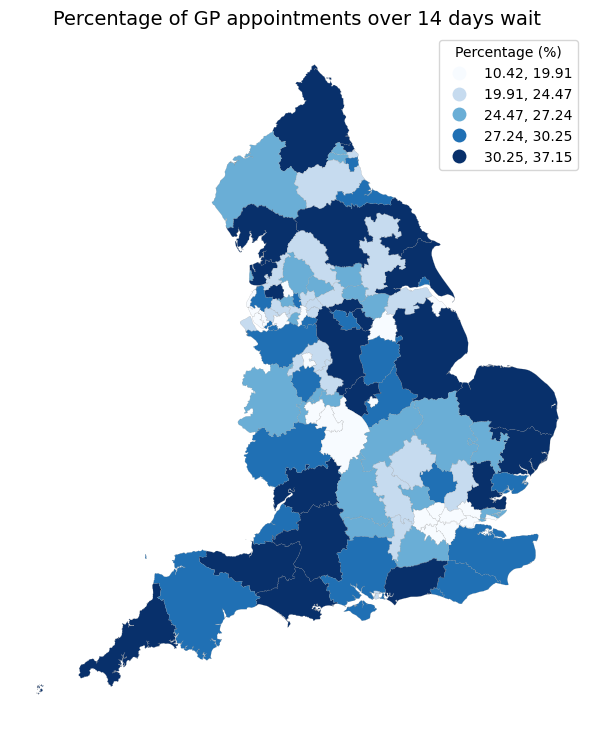

In [52]:
fig, ax = plt.subplots(1, figsize=(9, 9))
dataset_sicb23_geo.plot(column='pct_over14', cmap='Blues', 
        scheme='quantiles', k=5, 
        edgecolor='grey', linewidth=0.1,
        legend=True, legend_kwds={"title":'Percentage (%)',"loc": 'upper right'},
        ax=ax
       )
ax.set_axis_off()
ax.set_title("Percentage of GP appointments over 14 days wait", fontsize=14)

#plt.savefig('GP_Map.png', dpi=300, bbox_inches='tight', facecolor='none')